# Load & transform the data
# Implement logistic regression
# Train & predict
# 

In [1]:
# task 1
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv")
target = "win"
features = df.columns.drop(target)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# NOTE: standard scaling is handled through the pipeline (as it is more sensible)

In [2]:
# heavy lifting
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

class TorchLR(nn.Module, BaseEstimator, ClassifierMixin):

    def __init__(self, n_features=8, epochs=1000,
                 learning_rate=0.01, weight_decay=0):
        
        super(TorchLR, self).__init__()
        self.linear = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs

    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)        
        
        criterion = nn.BCELoss()
        optimizer = optim.SGD(self.parameters(),
                              lr=self.learning_rate,
                              weight_decay=self.weight_decay)
        #print(f"Setting learning rate to {self.learning_rate}.")
        #print(f"Training {self.epochs} epochs...")
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            y_hat = self.forward(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            #if (epoch+1) % 250 == 0:
            #    print(f"Epoch {epoch+1}/{self.epochs}, BCE Loss: {loss.item()}")
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        y_pred = self.forward(X).detach().numpy()
        return (y_pred > 0.5).astype(int)
    
    def predict_proba(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        y1 = self.forward(X).detach().numpy()
        y0 = 1 - y1
        return np.column_stack((y0, y1))
    
    # task 6
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        return self
    


In [3]:
class TorchEv:
    
    def __init__(self, pipe, X, y):
        self.pipe = pipe
        self.X = X
        self.y = y
        self.model = pipe.named_steps["model"]
        self.y_pred = pipe.predict(X)
        self.y_pred_proba = pipe.predict_proba(X)[:, 1]
    
    # task 5
    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.y, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def print_classification_report(self):
        print(classification_report(self.y, self.y_pred))
    
    def plot_roc_curve(self):
        auc = roc_auc_score(self.y, self.y_pred_proba)
        fpr, tpr, _ = roc_curve(self.y, self.y_pred_proba)
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.lineplot(x=fpr, y=tpr, linewidth=2)
        plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (AUC = {auc:.3f})")
        plt.show()
    
    # task 8
    def plot_feature_importance(self, feature_names):
        coefficients = self.model.linear.weight.detach().numpy().flatten()        
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Coefficient": coefficients
        })
        importance_df["AbsCoef"] = abs(importance_df["Coefficient"])
        importance_df = importance_df.sort_values("AbsCoef", ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance_df, x="Coefficient", y="Feature")
        plt.title("Feature Importance")
        plt.xlabel("Coefficient Value")
        plt.tight_layout()
        plt.show()

In [4]:
# task 3
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", TorchLR(n_features=8,
                      learning_rate=0.01,
                      epochs=1000))])

pipe.fit(X_train.values, y_train.values)

# accuracy on train and test sets
print(f"Train accuracy: {pipe.score(X_train.values, y_train.values)}")
print(f"Test accuracy: {pipe.score(X_test.values, y_test.values)}")

Train accuracy: 0.53375
Test accuracy: 0.535


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [5]:
# task 4
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", TorchLR(n_features=8,
                      learning_rate=0.01,
                      weight_decay=0.01,
                      epochs=1000))])
pipe.fit(X_train.values, y_train.values)

# accuracy on train and test sets
print(f"Train accuracy: {pipe.score(X_train.values, y_train.values)}")
print(f"Test accuracy: {pipe.score(X_test.values, y_test.values)}")

Train accuracy: 0.5325
Test accuracy: 0.565


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, p

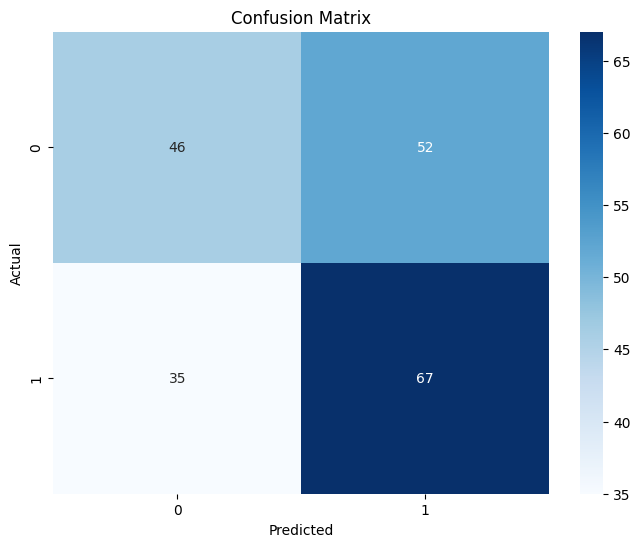

              precision    recall  f1-score   support

           0       0.57      0.47      0.51        98
           1       0.56      0.66      0.61       102

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.57      0.56      0.56       200



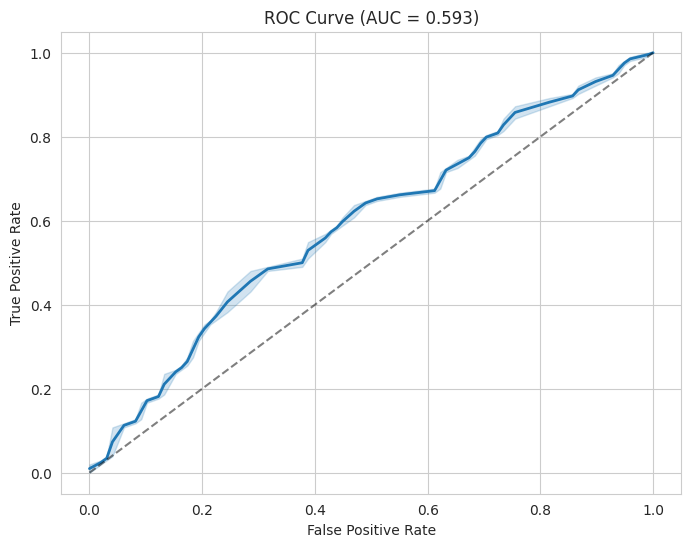

In [6]:
# task 5
eval = TorchEv(pipe, X_test, y_test)
eval.plot_confusion_matrix()
eval.print_classification_report()
eval.plot_roc_curve()

In [7]:
# task 6
pipe["model"].save("model.pth")
pipe["model"].load("model.pth")
# NOTE: the evaluation mode is abstracted in the upstream class
print(f"Test accuracy: {pipe.score(X_test.values, y_test.values)}")

Test accuracy: 0.565


/tmp/ipykernel_533228/1557644680.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/li

In [11]:
# task 7
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", TorchLR(n_features=8))
])

param_grid = {
    "model__epochs": [100, 250, 500, 1000],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__weight_decay": [0.01, 0.05, 0.1]
}

grid = GridSearchCV(pipe, param_grid,
                    cv=StratifiedKFold(n_splits=5),
                    n_jobs=5,
                    scoring="accuracy")
grid.fit(X_train.values, y_train.values)

/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.w

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', TorchLR())]),
             n_jobs=5,
             param_grid={'model__epochs': [100, 250, 500, 1000],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__weight_decay': [0.01, 0.05, 0.1]},
             scoring='accuracy')

In [12]:
print("Best accuracy:",grid.best_estimator_.score(X_test.values, y_test.values))
print("Best parameters:", grid.best_params_)

Best accuracy: 0.55
Best parameters: {'model__epochs': 100, 'model__learning_rate': 0.05, 'model__weight_decay': 0.05}


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, p

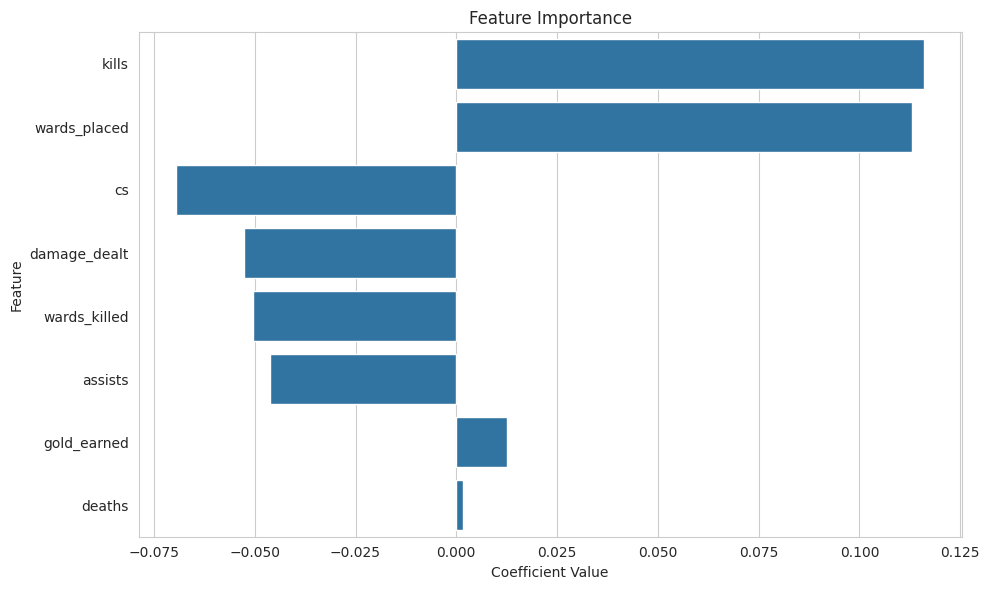

In [13]:
# task 8
# feature importance
eval = TorchEv(grid.best_estimator_, X_test, y_test)
eval.plot_feature_importance(features)  